<a href="https://colab.research.google.com/github/cameronliddle/Assignment/blob/main/PaddysCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

data_path = "/content/drive/MyDrive/PaddyMatthewsMachineLearningCA"
os.chdir(data_path)


In [ ]:
import pandas as pd

df_income = pd.read_csv("EDGrossIncome2016.csv", encoding='ISO-8859-1', skiprows=2, header=None)
df_income.columns = ["Index", "Electoral_Division", "Gross_Income"]
df_income = df_income[["Electoral_Division", "Gross_Income"]]
df_income["Electoral_Division"] = df_income["Electoral_Division"].str.strip()

df_ld = pd.read_csv("EDMedianGrossIncomeLDCommuter.csv", encoding='ISO-8859-1', skiprows=4, header=None)
df_ld.columns = ["Electoral_Division", "Median_Income_LD"]
df_ld["Electoral_Division"] = df_ld["Electoral_Division"].str.strip()

df_sd = pd.read_csv("EDMedianGrossIncomeSDCommuter.csv", encoding="ISO-8859-1", skiprows=4, header=None)
df_sd.columns = ["Electoral_Division", "Median_Income_SD"]
df_sd["Electoral_Division"] = df_sd["Electoral_Division"].str.strip()


In [ ]:

df_pension = pd.read_csv("EDPension.csv", encoding="ISO-8859-1", skiprows=4, header=None)
df_pension.columns = ["Electoral_Division", "Pension_Proportion"]
df_pension["Electoral_Division"] = df_pension["Electoral_Division"].str.strip()

df_welfare = pd.read_csv("EDSocialWelfare.csv", encoding="ISO-8859-1", skiprows=4, header=None)
df_welfare.columns = ["Electoral_Division", "Welfare_Proportion"]
df_welfare["Electoral_Division"] = df_welfare["Electoral_Division"].str.strip()


df_sector = pd.read_csv("EDProportionSector.csv", encoding="ISO-8859-1", skiprows=3, quotechar='"')
df_sector.columns = ["Year", "Electoral_Division", "Agriculture", "Construction", "Finance", "ICT", "Industry", "Public", "Wholesale"]
df_sector.drop(columns="Year", inplace=True)
df_sector["Electoral_Division"] = df_sector["Electoral_Division"].str.strip()


In [ ]:
merged_df = df_income.merge(df_ld, on="Electoral_Division", how="left") \
    .merge(df_sd, on="Electoral_Division", how="left") \
    .merge(df_pension, on="Electoral_Division", how="left") \
    .merge(df_welfare, on="Electoral_Division", how="left") \
    .merge(df_sector, on="Electoral_Division", how="left")


In [ ]:
df_saps = pd.read_csv("SAPS2016_ED3409.csv", encoding="ISO-8859-1", low_memory=False)
df_saps["ED_Name"] = df_saps["GEOGDESC"].str.strip()
saps_numeric = df_saps.drop(columns=["GUID", "GEOGID", "GEOGDESC"]).groupby("ED_Name", as_index=False).sum(numeric_only=True)


<ipython-input-18-593b8dde9db4>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  saps_numeric = df_saps.drop(columns=["GUID", "GEOGID", "GEOGDESC"]).groupby("ED_Name", as_index=False).sum(numeric_only=True)


In [ ]:
merged_df["ED_Name"] = (
    merged_df["Electoral_Division"]
    .str.replace(r"^\\d+\\s+", "", regex=True)
    .str.replace(r",.*", "", regex=True)
    .str.strip()
)

merged_df = merged_df.merge(df_saps[["ED_Name", "GEOGDESC"]].drop_duplicates(), on="ED_Name", how="left")
merged_df = merged_df.merge(saps_numeric, on="ED_Name", how="left")


In [ ]:
unmatched = merged_df[merged_df["GEOGDESC"].isna()].copy()
matched = merged_df[~merged_df["GEOGDESC"].isna()].copy()

saps_lookup = saps_numeric.set_index("ED_Name")
for idx, row in unmatched.iterrows():
    base = row["ED_Name"].split(" (")[0].strip()
    if base in saps_lookup.index:
        unmatched.loc[idx, saps_lookup.columns] = saps_lookup.loc[base].values
        unmatched.loc[idx, "GEOGDESC"] = f"{base} (from parent)"

final_df = pd.concat([matched, unmatched], ignore_index=True)


In [ ]:
final_df = final_df.dropna(axis=1, how='all')

threshold = 0.9 * len(final_df)
final_df = final_df.dropna(axis=1, thresh=threshold)

print("Cleaned dataset shape:", final_df.shape)
print("Remaining columns with missing values:\n", final_df.isnull().sum()[final_df.isnull().sum() > 0])


Cleaned dataset shape: (3410, 14)
Remaining columns with missing values:
 Median_Income_LD      308
Median_Income_SD      306
Pension_Proportion      2
Welfare_Proportion      2
Agriculture           122
Construction            5
Finance                 2
ICT                    10
Industry                7
Public                  1
Wholesale               1
dtype: int64


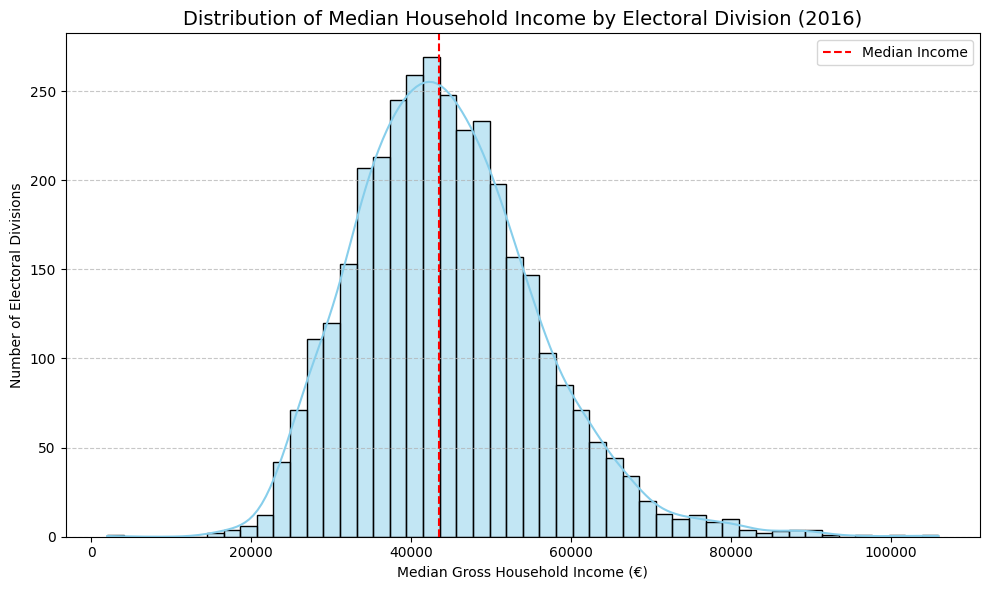

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

final_df["Gross_Income"] = pd.to_numeric(final_df["Gross_Income"], errors="coerce")

plt.figure(figsize=(10, 6))
sns.histplot(final_df["Gross_Income"].dropna(), bins=50, kde=True, color='skyblue')
plt.axvline(final_df["Gross_Income"].median(), color='red', linestyle='--', label='Median Income')
plt.title("Distribution of Median Household Income by Electoral Division (2016)", fontsize=14)
plt.xlabel("Median Gross Household Income (€)")
plt.ylabel("Number of Electoral Divisions")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


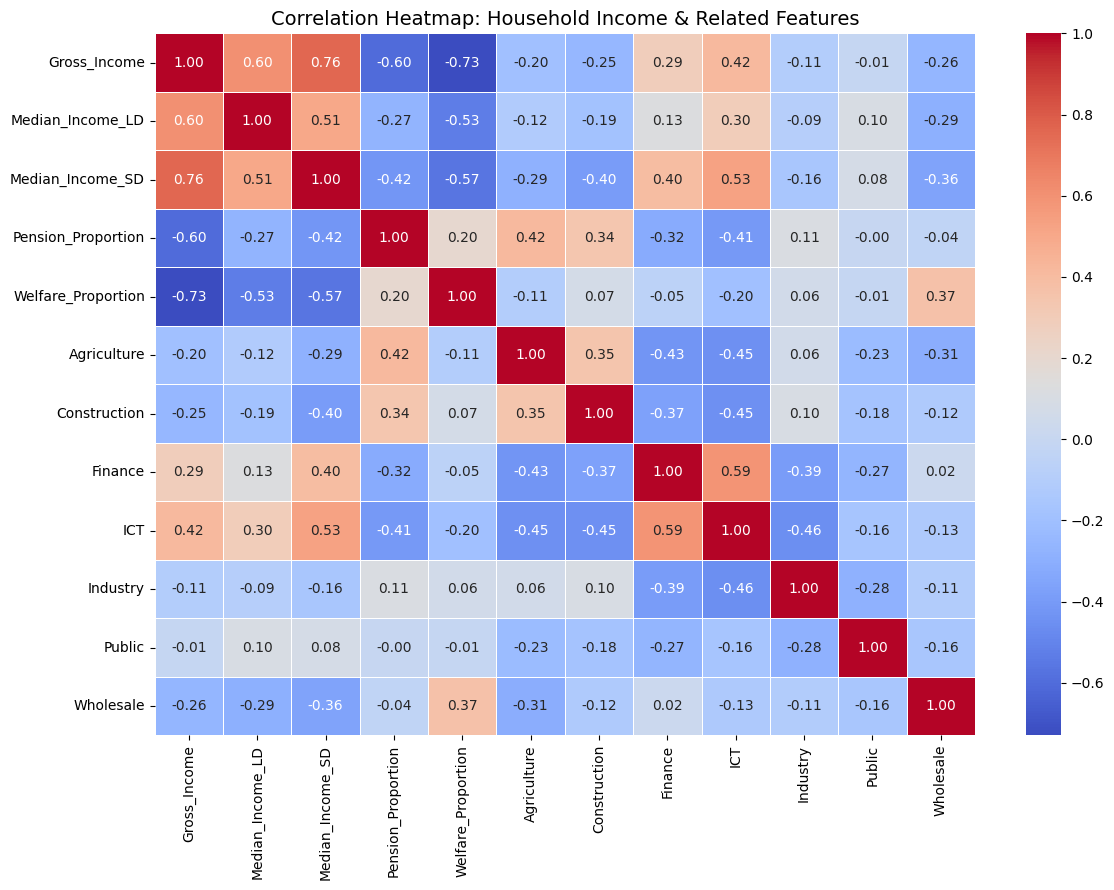

In [ ]:
correlation_columns = [
    "Gross_Income", "Median_Income_LD", "Median_Income_SD",
    "Pension_Proportion", "Welfare_Proportion",
    "Agriculture", "Construction", "Finance", "ICT", "Industry", "Public", "Wholesale"
]
corr_df = final_df[correlation_columns].apply(pd.to_numeric, errors='coerce')

corr_matrix = corr_df.corr()

plt.figure(figsize=(12, 9))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap: Household Income & Related Features", fontsize=14)
plt.tight_layout()
plt.show()


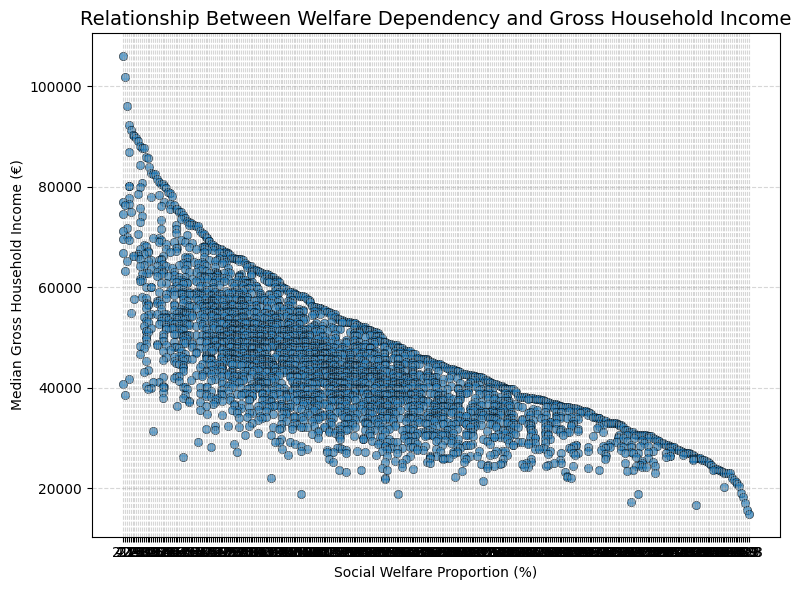

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=final_df,
    x="Welfare_Proportion",
    y="Gross_Income",
    alpha=0.7,
    edgecolor='k'
)
plt.title("Relationship Between Welfare Dependency and Gross Household Income", fontsize=14)
plt.xlabel("Social Welfare Proportion (%)")
plt.ylabel("Median Gross Household Income (€)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# Regression

In [ ]:
selected_features = [
    "Welfare_Proportion",
    "Pension_Proportion",
    "Agriculture", "Construction", "Finance", "ICT",
    "Industry", "Public", "Wholesale",
    "Median_Income_LD", "Median_Income_SD"
]

for col in selected_features + ["Gross_Income"]:
    final_df[col] = pd.to_numeric(final_df[col], errors='coerce')

model_df = final_df.dropna(subset=["Gross_Income"] + selected_features).copy()


X = model_df[selected_features]
y = model_df["Gross_Income"]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

linreg = LinearRegression()
rf = RandomForestRegressor(n_estimators=200, random_state=42)

linreg.fit(X_train, y_train)
rf.fit(X_train, y_train)

linreg_preds = linreg.predict(X_test)
rf_preds = rf.predict(X_test)


In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

def evaluate_model(name, y_true, y_pred):
    print(f"\n {name} Results")
    print("-" * (len(name) + 8))
    print(" R² Score      :", round(r2_score(y_true, y_pred), 3))
    print(" MAE (Euro)    :", round(mean_absolute_error(y_true, y_pred), 2))
    print(" RMSE (Euro)   :", round(np.sqrt(mean_squared_error(y_true, y_pred)), 2))

evaluate_model("Linear Regression (Filtered)", y_test, linreg_preds)
evaluate_model("Random Forest (Filtered)", y_test, rf_preds)



 Linear Regression (Filtered) Results
------------------------------------
 R² Score      : 0.846
 MAE (Euro)    : 3354.51
 RMSE (Euro)   : 4441.21

 Random Forest (Filtered) Results
--------------------------------
 R² Score      : 0.835
 MAE (Euro)    : 3313.17
 RMSE (Euro)   : 4587.4


<ipython-input-41-f0f69a8108e6>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette="Blues_r")


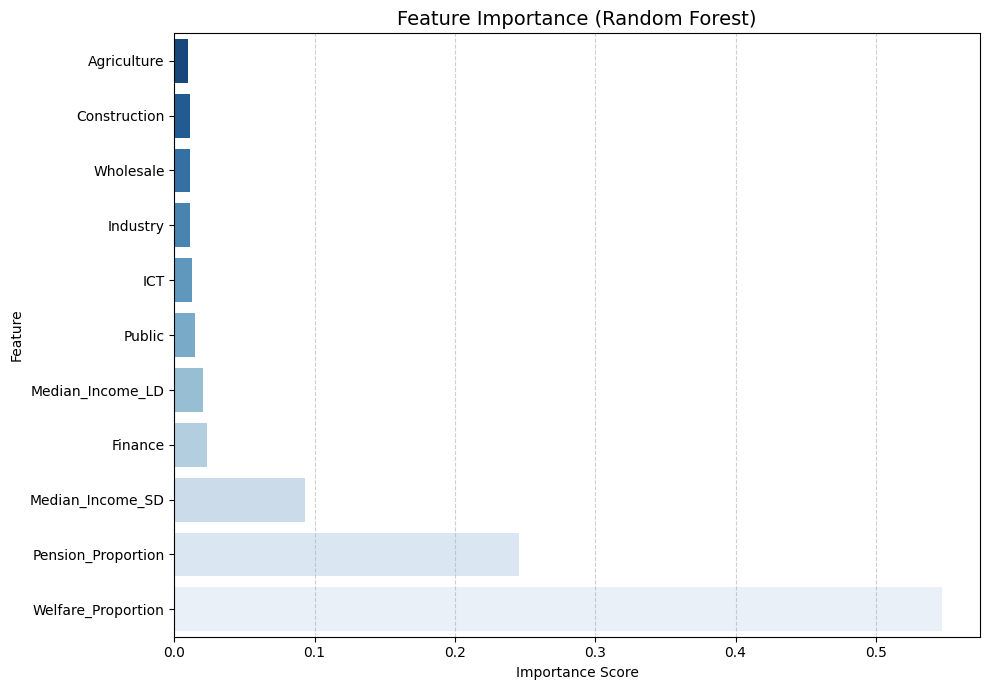

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

importances = pd.Series(rf.feature_importances_, index=X.columns)
top_features = importances.sort_values(ascending=True)

plt.figure(figsize=(10, 7))
sns.barplot(x=top_features.values, y=top_features.index, palette="Blues_r")
plt.title("Feature Importance (Random Forest)", fontsize=14)
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


#Classification

In [ ]:

quantiles = model_df["Gross_Income"].quantile([0.33, 0.67]).values

model_df["Income_Class"] = pd.cut(
    model_df["Gross_Income"],
    bins=[-float("inf"), quantiles[0], quantiles[1], float("inf")],
    labels=["Low", "Medium", "High"]
)


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X_cls = model_df[selected_features]
y_cls = model_df["Income_Class"]

X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
    X_cls, y_cls, test_size=0.2, random_state=42, stratify=y_cls
)

dtree = DecisionTreeClassifier(max_depth=4, random_state=42)
logreg = LogisticRegression(max_iter=1000)

dtree.fit(X_train_cls, y_train_cls)
logreg.fit(X_train_cls, y_train_cls)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

dtree_preds = dtree.predict(X_test_cls)
logreg_preds = logreg.predict(X_test_cls)

print("Decision Tree Classification Report:\n")
print(classification_report(y_test_cls, dtree_preds))

print("\nLogistic Regression Classification Report:\n")
print(classification_report(y_test_cls, logreg_preds))

print("\nAccuracy Scores:")
print("Decision Tree:", round(accuracy_score(y_test_cls, dtree_preds), 3))
print("Logistic Regression:", round(accuracy_score(y_test_cls, logreg_preds), 3))


Decision Tree Classification Report:

              precision    recall  f1-score   support

        High       0.81      0.79      0.80       198
         Low       0.86      0.71      0.78       198
      Medium       0.61      0.72      0.66       203

    accuracy                           0.74       599
   macro avg       0.76      0.74      0.75       599
weighted avg       0.76      0.74      0.75       599


Logistic Regression Classification Report:

              precision    recall  f1-score   support

        High       0.88      0.84      0.86       198
         Low       0.86      0.78      0.81       198
      Medium       0.67      0.76      0.72       203

    accuracy                           0.79       599
   macro avg       0.80      0.79      0.80       599
weighted avg       0.80      0.79      0.80       599


Accuracy Scores:
Decision Tree: 0.743
Logistic Regression: 0.793


# Clustering

In [ ]:
from sklearn.preprocessing import StandardScaler

X_cluster = model_df[selected_features].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)
model_df["Cluster"] = cluster_labels

sil_score = silhouette_score(X_scaled, cluster_labels)
print(f"Silhouette Score (k=3): {sil_score:.3f}")


Silhouette Score (k=3): 0.171


In [ ]:
cluster_summary = model_df.groupby("Cluster")["Gross_Income"].agg(["count", "mean", "median"]).sort_values("mean", ascending=False)
print(cluster_summary)


         count          mean   median
Cluster                              
1          362  59766.944751  59579.5
2         1844  46362.529826  45949.0
0          786  36246.405852  35388.0


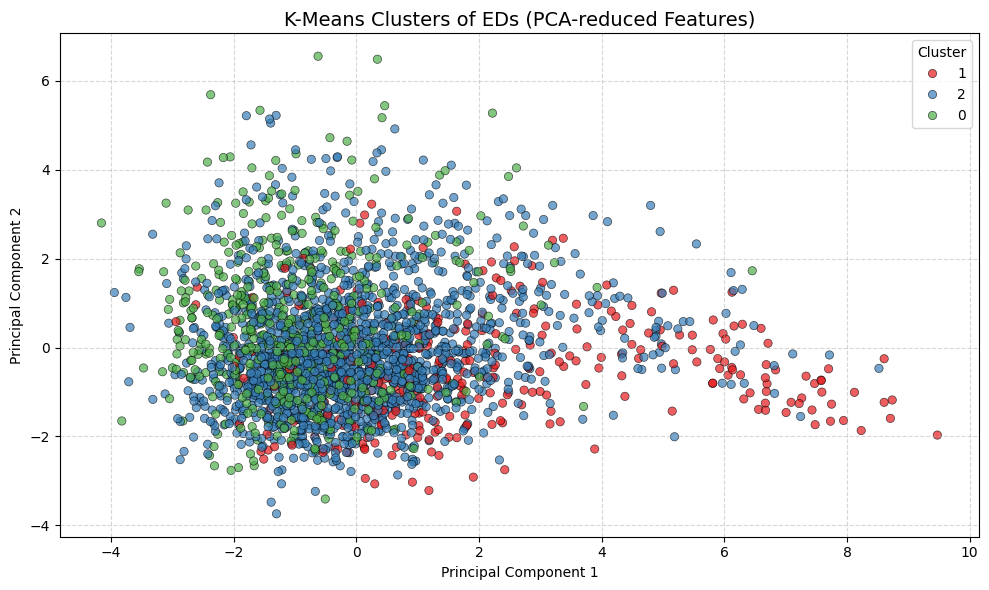

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
pca_df["Cluster"] = model_df["Cluster"].astype(str)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Cluster", palette="Set1", alpha=0.7, edgecolor="k")
plt.title("K-Means Clusters of EDs (PCA-reduced Features)", fontsize=14)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
cluster_profiles = model_df.groupby("Cluster")[selected_features].mean().round(2)

cluster_profiles = cluster_profiles.T
cluster_profiles.columns = [f"Cluster {i}" for i in cluster_profiles.columns]

print("Average Feature Values per Cluster:")
display(cluster_profiles)


Average Feature Values per Cluster:


,Cluster 0,Cluster 1,Cluster 2
Welfare_Proportion,19.09,7.62,10.41
Pension_Proportion,16.49,9.92,16.72
Agriculture,4.94,1.32,10.15
Construction,6.45,3.51,7.98
Finance,12.12,18.95,10.95
ICT,9.84,21.44,9.31
Industry,14.16,8.49,15.75
Public,30.18,29.53,29.26
Wholesale,22.31,16.76,16.60
Median_Income_LD,34433.29,44611.66,39371.96
